### Sequence processing with convnets

For sequenced data, if you consider time as one dimension you can use convnets to process them. They have been used with success for audio generation and machine translation. Additionally they are computationally cheaper than RNNs,showing an advantage in simple tasks such as text classification and timeseries forecasting. 

#### Understanding 1D convolution for sequence data

Analogous to the original 2D convolutional layers, here we extract *1D patches* from the sequences, which are in practice subsequences.

Following the same idea, a 1D conv layer can recognize patterns in several positions. In the case of characters, it can learn about word morphology. 

#### 1D pooling of sequence data

The same as original pooling (max, average) but in 1D. 

#### Implementing a 1D convne

In Keras we have the `Conv1D` layer, which is similar to `Conv2D`. It takes as input 3D tensors with shape `(samples, time, features)` and returns 3D tensors with the same shape. 

Let's use it on the IMDB sentiment-classification task:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [16]:
!pip install keras==2.0.8

     |████████████████████████████████| 276kB 36.4MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('loading data!')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# -----------------
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# restore np.load for future normal usage
np.load = np_load_old
# -----------------


print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))

loading data!
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import time

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy', 
              metrics=['acc'])

start = time.process_time()

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2) 

elapsed = time.process_time() - start
print('elapsed time: {:.3f} seconds'.format(elapsed))





Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable

Colab CPU time: 21.331 seconds

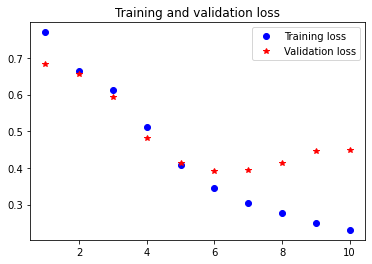

In [5]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

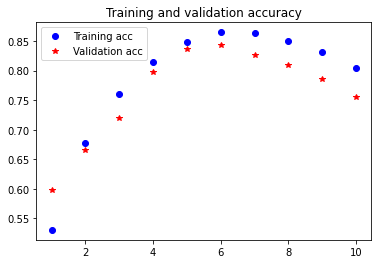

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r*', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

This training was very fast by using the GPU, only 21 seconds. We can adjust the hyperparameters of this network and compare it to the LSTM netweork we build previously. 

#### Combining CNNs and RNNs to process long sequences

It's harder for a 1D convnet to grasp large scale patters, even by using many convolutional and pooling layers. Let's show it by using them in the **jena** dataset:

In [7]:
!pwd

/content


In [8]:
cd /content/drive/My Drive/kaggle

/content/drive/My Drive/kaggle


In [9]:
!pwd

/content/drive/My Drive/kaggle


Let's load the data again

In [10]:
import os
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [0]:
# normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, 
                               max_index, 
                               size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows),
                        lookback // step, 
                        data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

#### Training and evaluating a simple 1D convnet on the Jena data

Now we can continue with the model implementation

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import time

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

start = time.process_time()

history2 = model.fit_generator(train_gen, 
                               steps_per_epoch=500, 
                               epochs=20, 
                               validation_data=val_gen, 
                               validation_steps=val_steps)

elapsed = time.process_time() - start
print('elapsed time: {:.3f} seconds'.format(elapsed))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

 Colab GPU time: 322.024 seconds -> 5.36 minutes  
 Colab GPU time (keras==2.0.8) -> 326.965 seconds -> 5.45 minutes (but results are closer to the book ones)

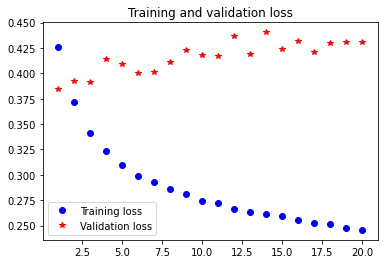

In [17]:
import matplotlib.pyplot as plt

loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Preparing higher-resolution data generators for the Jena dataset

In [0]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [0]:
#### Model combining a 1D conv base and a GRU layer

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import time

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', 
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

start = time.process_time()

history3 = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

elapsed = time.process_time() - start
print('elapsed time: {:.3f} seconds'.format(elapsed))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
________________

Colab GPU time (keras==2.0.8): 1632.133 seconds -> 27.20 minutes

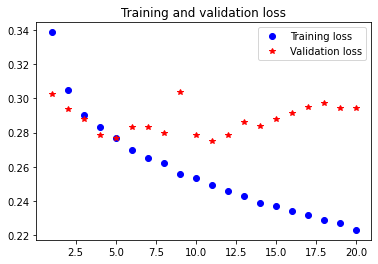

In [22]:
import matplotlib.pyplot as plt

loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r*', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It does not perform as well as the original GRU layer, but it's much faster. Taking into acount that we are analyzing more data since we changed the `step` parameter to half the previous value, meaning we have doubled the input data. 

#### Wrapping up

1D convnets perform well for processing temporal patterns, offering a faster alternative to RNNs in problems such as NLP. 

The structure of 1D convnets is similar to 2D convnets: it has stacks of `Conv1D` and  `Maxpooling1D` layers ended by a global pooling layer that plays the role of the `Flatten` layer in the case of 2D convnets.

To ease the computational load, it is a common practice to use 1D convnets as a preprocessing step before feeding in an RNNs network. 